## Importy

In [2]:
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.cluster import KMeans
from collections import Counter

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import unique_columns as qc 
import data_transform as dt 
import utils as h

### Wczytanie danych
Cel zadania to prognozowanie ceny laptopa (buynow_price), metryką sukcesu jest RMSE. By utrzymać porządek w kodzie, funkcje z których korzystam znajdują się w osobnych plikach: 
- data_tranfsorm.py - funkcję używane do przekształceń danych 
- utils.py - funkcję pomocnicze do prognozowanie, narysowania krzywej uczenia itd 
- unique_columns.py - plik z zapisanymi nazwami kolumn do one hot encodingu zmienych, zapisany by zachować spójność, podczas przetwarzania plików z danymi 

In [3]:
df = pd.read_json("data/public-dataset.json")
df.reset_index(inplace=True)
df = df.drop('index', axis=1) 
df.sample(5)

,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy
5185,2659.00,grafika dedykowana,[nfc (near field communication)],1920 x 1080,2,4 gb,[windows 10 home],hdd,[touchpad],"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.4,intel core i3,nowy,1000.0,producenta,"14"" - 14.9"""
6851,2999.00,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,16 gb,"[windows 10 home, inny]",hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,2.5,intel core i7,nowy,1500.0,producenta,"17"" - 17.9"""
5823,1699.00,grafika zintegrowana,None,1366 x 768,3,4 gb,[windows 10 home],None,[touchpad],"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,64.0,producenta,"14"" - 14.9"""
7826,3319.00,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.9,intel core i3,nowy,960.0,producenta,"15"" - 15.9"""
566,3616.01,grafika dedykowana,"[bluetooth, lan 10/100/1000 mbps]",2880 x 1620,4,8 gb,[windows 10 professional],hybrydowy,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,2.5,intel core i7,nowy,500.0,sprzedawcy,"15"" - 15.9"""


### Braki w danych 
Zostaną uzupełnione później na razie spawdzam jaki jest to rząd wielkośći (procent) oraz jakich cech dotyczy 

In [4]:
h.check_missing(df)

('rodzaj karty graficznej', 6.316057557621291)
('komunikacja', 9.9579778428626)
('rozdzielczość (piksele)', 7.742264102890615)
('wielkość pamięci ram', 5.730294155099962)
('system operacyjny', 8.277091557366612)
('typ dysku twardego', 5.539284349929963)
('sterowanie', 8.633643193683943)
('multimedia', 9.01566280402394)
('typ pamięci ram', 11.002164777791927)
('taktowanie bazowe procesora (ghz)', 11.91901184260792)
('seria procesora', 6.787215077040622)
('pojemność dysku (gb)', 6.125047752451293)
('wielkość matrycy ', 4.405959505921304)


### Typ danych
Odkodowuje dane do bardziej przejrzystej postaci: 
- dane które są zapisane w postaci array ([]) odkodowuje na zmienne one hot encoding tworząc nową cechę, 
- wielkość pamięci ram zamieniam na gb i zapisuje jako int, 
- wielkość matrycy zamieniam na int biorąc pierwszą wartość z przedziału czyli dla 14" - 14.9" będę mieć 14 
- typ dysku twardego mam sytację że mam 2 dyski twarde ssd + hdd wiec zmieniam ta cechę na zmienna one hot encoding 

In [5]:
preprocessor = Pipeline(steps=[('mlb_komunikacja',  dt.DFTransform(lambda df: dt._one_hot_encoding(df,'komunikacja', qc.komunikacja))),
                      ('mlb_sterowanie',  dt.DFTransform(lambda df: dt._one_hot_encoding(df, 'sterowanie', qc.sterowanie ))),
                      ('mlb_multimedia',  dt.DFTransform(lambda df: dt._one_hot_encoding(df, 'multimedia', qc.multimedia))),
                      ('mlb_system_operacyjny',  dt.DFTransform(lambda df: dt._one_hot_encoding(df,'system operacyjny', qc.system_operacyjny))),
                      ('ram',  dt.RamTransform()),
                      ('matryca',  dt.DFTransform(lambda df: dt._matryca(df, 'wielkość matrycy '))),
                      ('dysk_trwardy',  dt.DFTransform(lambda df: dt._dysk_twardy(df, 'typ dysku twardego'))),
                      ('mlb_dysk_twardy',  dt.DFTransform(lambda df: dt._one_hot_encoding(df, 'typ dysku twardego', qc.typ_dysku_twardego)))
                     ])

df = preprocessor.fit_transform(df)

/Users/ewa.suknarowska/.pyenv/versions/3.7.9/envs/lpp/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:861: UserWarning: unknown class(es) ['inny'] will be ignored
  .format(sorted(unknown, key=str)))


In [6]:
pd.set_option('display.max_columns', None)
df.sample(5)

,buynow_price,rodzaj karty graficznej,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy,modem 3g (wwan)_ohe,wi-fi 802.11 a/b/g/n/ac_ohe,wi-fi 802.11 b/g/n/ac_ohe,wi-fi 802.11 a/b/g/n_ohe,modem 4g (lte)_ohe,gps_ohe,intel wireless display (widi)_ohe,nfc (near field communication)_ohe,bluetooth_ohe,wi-fi 802.11 b/g/n_ohe,lan 10/100/1000 mbps_ohe,wi-fi_ohe,lan 10/100 mbps_ohe,klawiatura_ohe,touchpad_ohe,klawiatura podświetlana_ohe,klawiatura numeryczna_ohe,kamera_ohe,czytnik kart pamięci_ohe,mikrofon_ohe,głośniki_ohe,windows 10 home_ohe,windows 7 professional 64-bit_ohe,windows 10 professional_ohe,brak systemu_ohe,windows 8.1 professional 64-bit_ohe,windows 8.1 home 64-bit_ohe,windows 7 home 64-bit_ohe,windows 8.1 home 32-bit_ohe,windows 7 professional 32-bit_ohe,linux_ohe,windows 8.1 professional 32-bit_ohe,emmc_ohe,hdd_ohe,hybrydowy_ohe,ssd_ohe
6369,2599.0,grafika zintegrowana,1920 x 1080,2,12.0,ddr4,2.4,intel core i3,nowy,240.0,producenta,15.0,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5581,2399.0,grafika dedykowana,1920 x 1080,2,8.0,ddr3,2.3,intel core i5,nowy,256.0,producenta,15.0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
585,2383.0,grafika dedykowana,1366 x 768,2,8.0,ddr4,NaN,intel core i3,nowy,240.0,producenta,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4314,2899.0,grafika dedykowana,1920 x 1080,2,8.0,ddr4,2.5,intel core i5,nowy,128.0,producenta,15.0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3056,2279.0,None,1920 x 1080,4,4.0,ddr4,2.7,amd a12,nowy,1000.0,producenta,15.0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### Analiza danych
Stosuje funkcje pomocnicze do lepszego wybierania kolumn. 

In [7]:
one_hot_encoding_features = h.get_one_hot_encoding_features (df,qc.komunikacja + qc.multimedia + qc.sterowanie + qc.typ_dysku_twardego + qc.system_operacyjny )
categorical_features = df.select_dtypes(include=[np.object]).columns.tolist()
numeric_features = h.get_numeric_features(df,one_hot_encoding_features)

/Users/ewa.suknarowska/.pyenv/versions/3.7.9/envs/lpp/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [8]:
df.describe()

,buynow_price,wielkość pamięci ram,taktowanie bazowe procesora (ghz),pojemność dysku (gb),wielkość matrycy,modem 3g (wwan)_ohe,wi-fi 802.11 a/b/g/n/ac_ohe,wi-fi 802.11 b/g/n/ac_ohe,wi-fi 802.11 a/b/g/n_ohe,modem 4g (lte)_ohe,gps_ohe,intel wireless display (widi)_ohe,nfc (near field communication)_ohe,bluetooth_ohe,wi-fi 802.11 b/g/n_ohe,lan 10/100/1000 mbps_ohe,wi-fi_ohe,lan 10/100 mbps_ohe,klawiatura_ohe,touchpad_ohe,klawiatura podświetlana_ohe,klawiatura numeryczna_ohe,kamera_ohe,czytnik kart pamięci_ohe,mikrofon_ohe,głośniki_ohe,windows 10 home_ohe,windows 7 professional 64-bit_ohe,windows 10 professional_ohe,brak systemu_ohe,windows 8.1 professional 64-bit_ohe,windows 8.1 home 64-bit_ohe,windows 7 home 64-bit_ohe,windows 8.1 home 32-bit_ohe,windows 7 professional 32-bit_ohe,linux_ohe,windows 8.1 professional 32-bit_ohe,emmc_ohe,hdd_ohe,hybrydowy_ohe,ssd_ohe
count,7853.000000,7403.000000,6917.00000,7372.000000,7507.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.00000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000,7853.000000
mean,3475.527050,9.780664,2.33743,653.239826,14.932729,0.830765,0.034254,0.127849,0.356170,0.504393,0.128486,0.03400,0.185152,0.376671,0.002165,0.018210,0.009296,0.021138,0.865529,0.438304,0.334012,0.911117,0.858907,0.840443,0.895072,0.845664,0.168089,0.000255,0.521966,0.177384,0.000509,0.000382,0.031962,0.001783,0.017318,0.000382,0.002674,0.011843,0.442761,0.010951,0.625111
std,1730.904165,6.532760,0.39109,477.616013,1.059829,0.374983,0.181894,0.333943,0.478897,0.500013,0.334651,0.18124,0.388446,0.484582,0.046480,0.133717,0.095972,0.143855,0.341179,0.496211,0.471674,0.284593,0.348139,0.366218,0.306480,0.361293,0.373969,0.015958,0.499549,0.382018,0.022565,0.019543,0.175911,0.042188,0.130463,0.019543,0.051646,0.108184,0.496744,0.104080,0.484125
min,429.000000,0.256000,0.00000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2199.000000,4.000000,2.00000,256.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3149.000000,8.000000,2.50000,500.000000,15.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4399.000000,12.000000,2.60000,1000.000000,15.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,15472.650000,64.000000,3.90000,10000.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000

Wnioski: 
- zmienne 'wielkość pamięci ram' 
- pojemność dysku (gb) może warto bedzie znomalizować 

###### Target

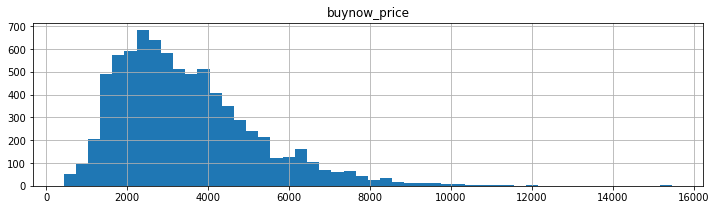

In [9]:
fig, ax = plt.subplots(figsize=(12,3))
df['buynow_price'].hist(bins =50)
plt.title('buynow_price');

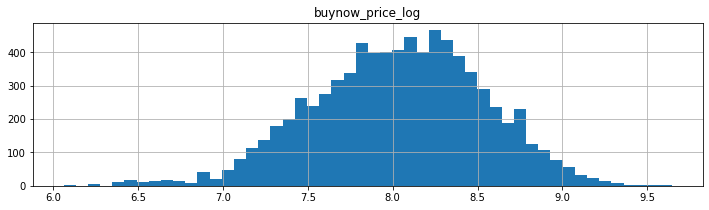

In [10]:
fig, ax = plt.subplots(figsize=(12,3))
np.log(df['buynow_price']).hist(bins =50)
plt.title('buynow_price_log');

###### Features 

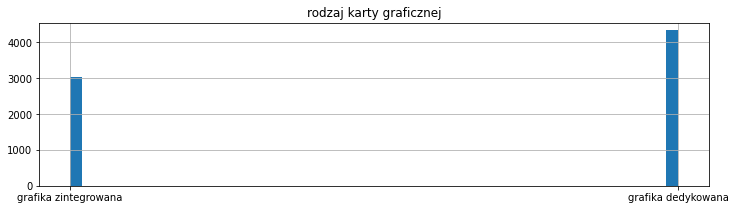

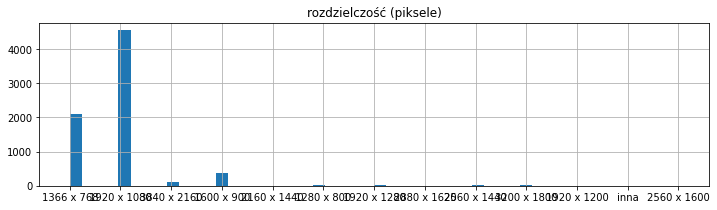

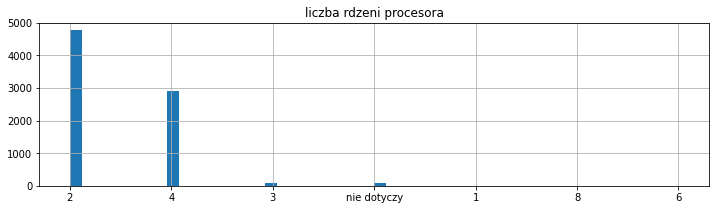

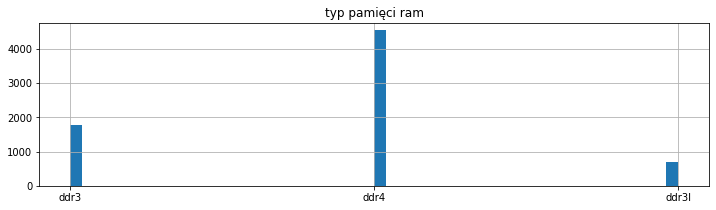

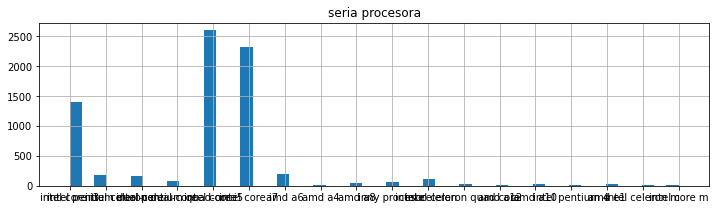

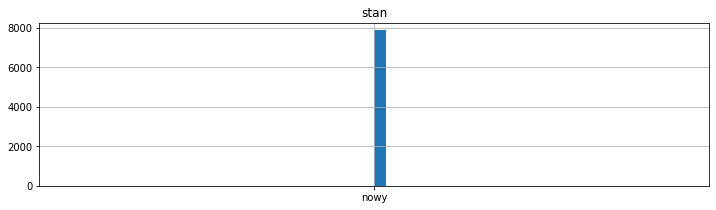

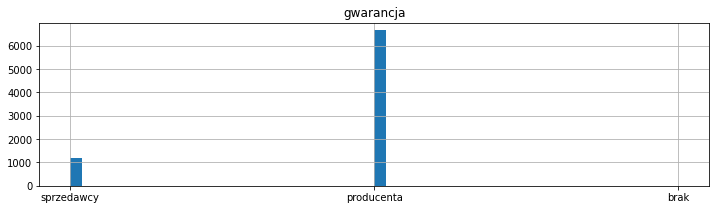

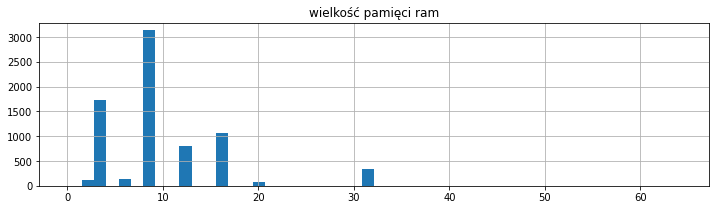

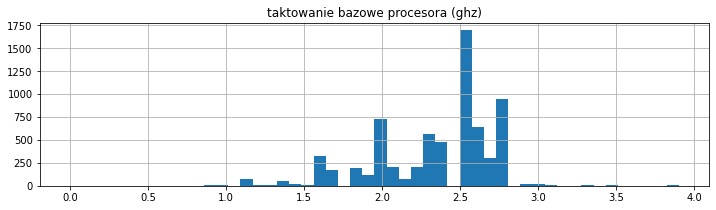

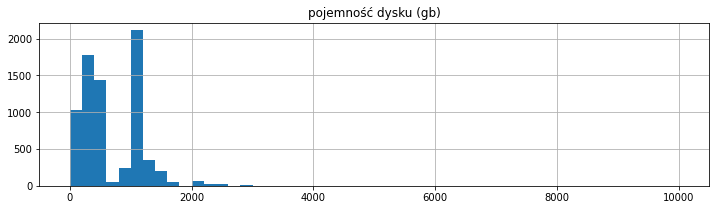

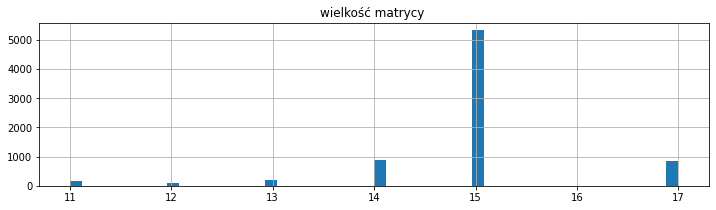

In [11]:
for column in categorical_features + numeric_features: 
    fig, ax = plt.subplots(figsize=(12,3))
    df[column].hist(bins =50)
    plt.title(column)

Wnioski: 
- buynow_price - ma skrzywiony rozkład, najprawodopodbniej pomocne będzie zastosowanie logarytmu 
- rodzaj karty graficzej można zaminić na hot_one_ecoding lub ordinal_encoder
- rozdzielczość (piksele) zamienić "inna" na NaN może połaczyć klasy na mało, średnio, dużo?  
- liczba rdzeni procesora zamienić "nie dotyczy" na NaN 
- wielość pamięci ram - sprawdzić wartość odstającą? 
- stan - ta zmienna nie wnosi nic nowego 
- pojemność dysku - sprawdzić wartość odstającą? 
- wi-fi - może połaczyć w jedną cechę? 
- lan - tjw. 
- zastanowić jak się uzupełnić braki przy mlb? 

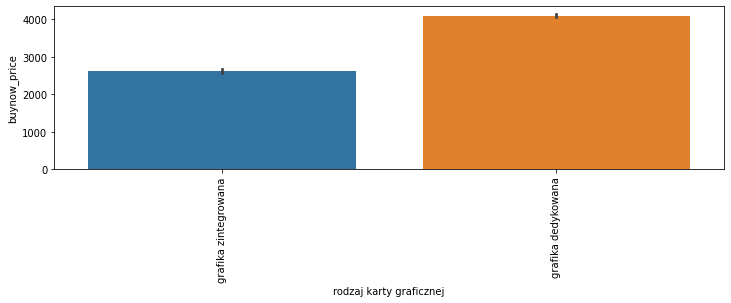

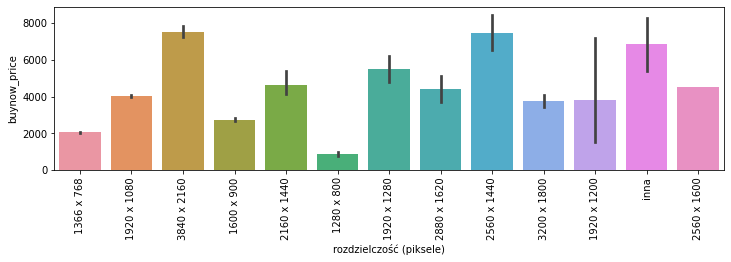

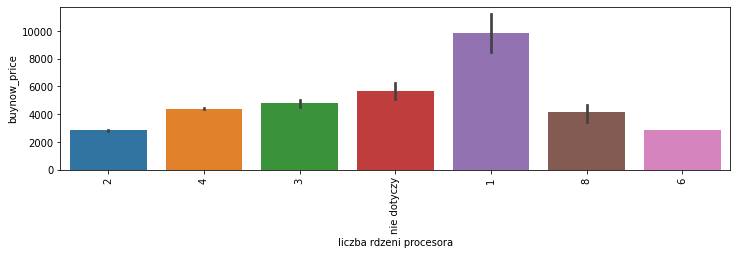

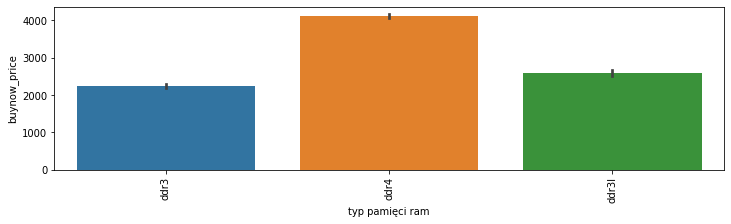

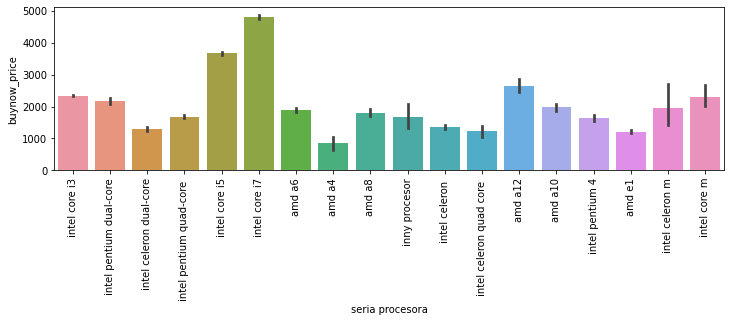

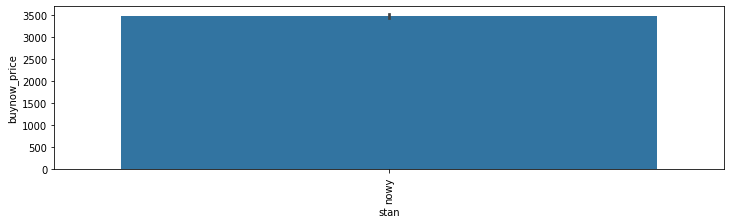

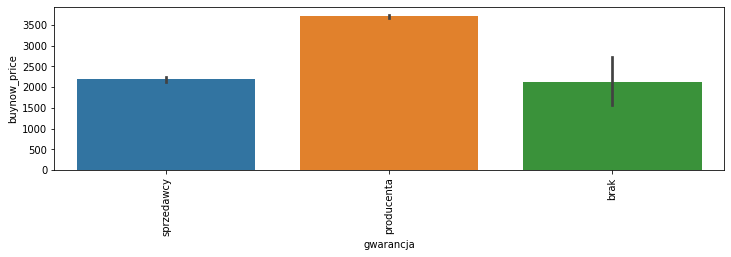

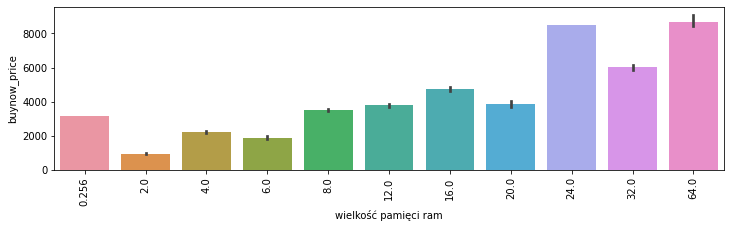

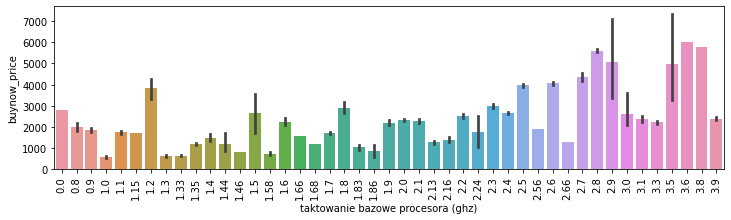

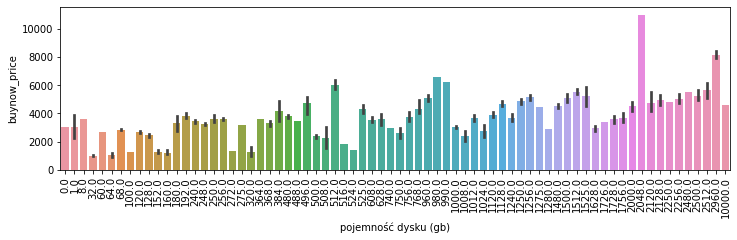

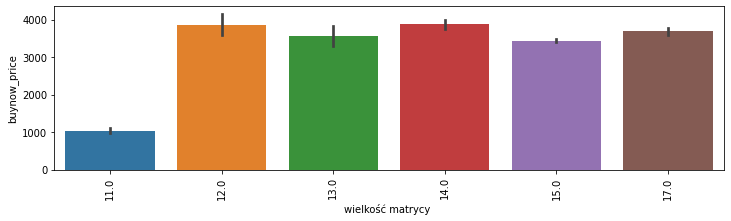

In [12]:
for i in categorical_features + numeric_features: 
    plt.figure(figsize=(12, 3))
    sns.barplot(x=i, y="buynow_price", data=df)
    plt.xticks(rotation=90);

Wyższe ceny osiągają laptopy z:  
- dedykowana kartą graficzną 
- z ddr4 pamięcią ram
- z prosesorem intel core i5 lub i7 
- grarancją od procudenta
- im wiekszą pamieć ram tym lepiej 

###### Wiersze które wyglądaja podejrzanie: 
Postanawiam je usunać z dalszego procesu uczenia. Ponieważ wygląda to tak jakby 1 była wartością domyślą i została wpisana tylko cena 

In [13]:
df[df['liczba rdzeni procesora'] == '1']

,buynow_price,rodzaj karty graficznej,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy,modem 3g (wwan)_ohe,wi-fi 802.11 a/b/g/n/ac_ohe,wi-fi 802.11 b/g/n/ac_ohe,wi-fi 802.11 a/b/g/n_ohe,modem 4g (lte)_ohe,gps_ohe,intel wireless display (widi)_ohe,nfc (near field communication)_ohe,bluetooth_ohe,wi-fi 802.11 b/g/n_ohe,lan 10/100/1000 mbps_ohe,wi-fi_ohe,lan 10/100 mbps_ohe,klawiatura_ohe,touchpad_ohe,klawiatura podświetlana_ohe,klawiatura numeryczna_ohe,kamera_ohe,czytnik kart pamięci_ohe,mikrofon_ohe,głośniki_ohe,windows 10 home_ohe,windows 7 professional 64-bit_ohe,windows 10 professional_ohe,brak systemu_ohe,windows 8.1 professional 64-bit_ohe,windows 8.1 home 64-bit_ohe,windows 7 home 64-bit_ohe,windows 8.1 home 32-bit_ohe,windows 7 professional 32-bit_ohe,linux_ohe,windows 8.1 professional 32-bit_ohe,emmc_ohe,hdd_ohe,hybrydowy_ohe,ssd_ohe
773,12030.0,None,None,1,NaN,None,NaN,None,nowy,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2105,10790.0,None,None,1,NaN,None,NaN,None,nowy,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3099,9770.0,None,None,1,NaN,None,NaN,None,nowy,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,6510.0,None,None,1,NaN,None,NaN,None,nowy,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4253,9610.0,None,None,1,NaN,None,NaN,None,nowy,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4352,12090.0,None,None,1,NaN,None,NaN,None,nowy,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6152,8370.0,None,None,1,NaN,None,NaN,None,nowy,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df = df[df['liczba rdzeni procesora'] != '1']

###  Feature Engineering
- Rozdzielczość (piksele) zamienić za 2 grupy Full HD, nie Full HD 
- Czy intel i5 i7 
- Łączenie kolumn (wifi, lan) 

Przekształcenia zostały dodane do pipeline:

In [15]:
feature_engineering  = Pipeline(steps=[
            ('remove_inna',  dt.DFTransform(lambda df: dt._replace(df, 'rozdzielczość (piksele)','inna'))),
            ('remove_nie_dotyczy',  dt.DFTransform(lambda df: dt._replace(df, 'liczba rdzeni procesora','nie dotyczy'))),
            ('drop_stan' , dt.DFTransform(lambda df: dt._drop(df, 'stan'))),
            ('piksele', dt.DFTransform(lambda df: dt._piksele(df, 'rozdzielczość (piksele)'))),
            ('intel_i5_i7', dt.DFTransform(lambda df: dt._seria_procesora(df, 'seria procesora'))),
            ('wifi', dt.DFTransform(lambda df:  dt._join_column(df,['wi-fi 802.11 a/b/g/n/ac_ohe','wi-fi 802.11 b/g/n/ac_ohe','wi-fi 802.11 a/b/g/n_ohe','wi-fi 802.11 b/g/n_ohe','wi-fi_ohe'],'wifi'))),
            ('lan', dt.DFTransform(lambda df: dt._join_column(df,['lan 10/100/1000 mbps_ohe','lan 10/100 mbps_ohe'],'lan')))
             ])

df = feature_engineering.fit_transform(df)

In [16]:
df.sample(5)

,buynow_price,rodzaj karty graficznej,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,pojemność dysku (gb),gwarancja,wielkość matrycy,modem 3g (wwan)_ohe,wi-fi 802.11 a/b/g/n/ac_ohe,wi-fi 802.11 b/g/n/ac_ohe,wi-fi 802.11 a/b/g/n_ohe,modem 4g (lte)_ohe,gps_ohe,intel wireless display (widi)_ohe,nfc (near field communication)_ohe,bluetooth_ohe,wi-fi 802.11 b/g/n_ohe,lan 10/100/1000 mbps_ohe,wi-fi_ohe,lan 10/100 mbps_ohe,klawiatura_ohe,touchpad_ohe,klawiatura podświetlana_ohe,klawiatura numeryczna_ohe,kamera_ohe,czytnik kart pamięci_ohe,mikrofon_ohe,głośniki_ohe,windows 10 home_ohe,windows 7 professional 64-bit_ohe,windows 10 professional_ohe,brak systemu_ohe,windows 8.1 professional 64-bit_ohe,windows 8.1 home 64-bit_ohe,windows 7 home 64-bit_ohe,windows 8.1 home 32-bit_ohe,windows 7 professional 32-bit_ohe,linux_ohe,windows 8.1 professional 32-bit_ohe,emmc_ohe,hdd_ohe,hybrydowy_ohe,ssd_ohe,rozdzielczość (piksele)_fe,seria procesora_fe,wifi_fe,lan_fe
4099,3419.0,grafika dedykowana,1600 x 900,2,8.0,ddr3,2.3,intel core i5,480.0,producenta,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
5916,1899.0,grafika zintegrowana,1920 x 1080,2,4.0,ddr3,1.9,intel pentium dual-core,1000.0,sprzedawcy,14.0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
2738,2799.0,grafika dedykowana,1600 x 900,2,4.0,ddr3l,2.3,intel core i3,128.0,producenta,17.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7077,1649.0,grafika dedykowana,1366 x 768,2,4.0,ddr3,2.0,intel core i3,120.0,producenta,15.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7313,1899.0,None,None,2,NaN,None,NaN,None,NaN,producenta,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


### Base Line 
Zamiana na wartość numeryczne i uzupełnienie braków:
- Zmienne one hot encoding uzupełniam -1, nie chce 0 które wskazywałyby że czegoś nie ma -1 daje mi informację ze nie wiem co tam powinno się znaleść
- dane kategorialne/numeryczne uzupełniam najcześćiej pojawiąjące się wartościa,

In [17]:
one_hot_encoding_features = h.get_one_hot_encoding_features (df,qc.komunikacja + qc.multimedia + qc.sterowanie + qc.typ_dysku_twardego + qc.system_operacyjny ) 
one_hot_encoding_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value = -1))
])

engineering_features = [col for col in df if col.endswith('_fe')]
engineering_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value = -1))
])

categorical_features = df.select_dtypes(include=[np.object]).columns.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=None, strategy='most_frequent')),
    ('label', OrdinalEncoder(handle_unknown='ignore') )
])

numeric_features = h.get_numeric_features(df,one_hot_encoding_features+engineering_features)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = -1))
    ])

converting_data_to_numbers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('hot',one_hot_encoding_transformer,one_hot_encoding_features),
        ('eng',engineering_transformer,engineering_features)
    ])

pipeline = Pipeline(steps=[('converting_data_to_numbers', converting_data_to_numbers),
                            ('model',DummyRegressor(strategy='median'))]) ## rozkład jest skrzywiony wiec mediana powinna być bardziej precyzyjna 

/Users/ewa.suknarowska/.pyenv/versions/3.7.9/envs/lpp/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Mając dane w postaci numerycznej mogę zastosować DummyRegressor ze stategią mediana. Działa on na tej zasadzie, że zawszę będzię prognozować cenę jako mediana wszystkich cen w zbiorze uczącym. Obliczam RMSE, które wynosi 1749. Budując jakiekolwiek rozwiązanie wynik powinnien być lepszy niź ten. Jeśli będzie gorszy mogę podejrzewać że coś robię nie tak. Jest to średni błąd więc liczę go na całym zbiorze 

In [18]:
y = df['buynow_price'].values
h.train_and_predict(pipeline, df, y)

1749.7231066278814

### Eksperymenty

Wracam z df, tak jest mi prościej ekperymentować z cechami. Sprawdzę:
- jak działają inne modele regresji, 
- czy dodane wcześniej cechy poprawią jakoś modelu,
- czy prognozowanie logarytmu i odkręcanie predykcji poprawi jakoś modelu 

W funkcji run_cv stosuje walidację krzyżową do ocenny jakości (dlatego też nie dzieliłam wcześniej zbioru na train/test). Do oceny overfiffingu sugeruję się krzywą uczenia 

In [19]:
get_x = Pipeline(steps=[('converting_data_to_numbers', converting_data_to_numbers)])
columns_names = h.get_feature_names(get_x['converting_data_to_numbers'].transformers)
df_exp  = pd.DataFrame(get_x.fit_transform(df),columns=columns_names)

In [20]:
df_exp.sample(5)

,wielkość pamięci ram,taktowanie bazowe procesora (ghz),pojemność dysku (gb),wielkość matrycy,rodzaj karty graficznej,rozdzielczość (piksele),liczba rdzeni procesora,typ pamięci ram,seria procesora,gwarancja,modem 3g (wwan)_ohe,wi-fi 802.11 a/b/g/n/ac_ohe,wi-fi 802.11 b/g/n/ac_ohe,wi-fi 802.11 a/b/g/n_ohe,modem 4g (lte)_ohe,gps_ohe,intel wireless display (widi)_ohe,nfc (near field communication)_ohe,bluetooth_ohe,wi-fi 802.11 b/g/n_ohe,lan 10/100/1000 mbps_ohe,wi-fi_ohe,lan 10/100 mbps_ohe,klawiatura_ohe,touchpad_ohe,klawiatura podświetlana_ohe,klawiatura numeryczna_ohe,kamera_ohe,czytnik kart pamięci_ohe,mikrofon_ohe,głośniki_ohe,windows 10 home_ohe,windows 7 professional 64-bit_ohe,windows 10 professional_ohe,brak systemu_ohe,windows 8.1 professional 64-bit_ohe,windows 8.1 home 64-bit_ohe,windows 7 home 64-bit_ohe,windows 8.1 home 32-bit_ohe,windows 7 professional 32-bit_ohe,linux_ohe,windows 8.1 professional 32-bit_ohe,emmc_ohe,hdd_ohe,hybrydowy_ohe,ssd_ohe,rozdzielczość (piksele)_fe,seria procesora_fe,wifi_fe,lan_fe
7672,8.0,2.6,256.0,15.0,0.0,3.0,2.0,2.0,13.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2342,4.0,2.3,128.0,12.0,1.0,3.0,0.0,2.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
6034,8.0,2.0,1000.0,15.0,0.0,3.0,0.0,1.0,11.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7093,8.0,2.5,1000.0,15.0,0.0,3.0,0.0,2.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1257,4.0,1.9,256.0,13.0,1.0,1.0,0.0,0.0,13.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [21]:
feats = one_hot_encoding_features+categorical_features+numeric_features
X = df_exp[feats].values

In [22]:
h.run_cv(DummyRegressor(strategy='median'),X, y, folds=3)

(1750.711235419429, 15.666857364230443)

[LinearRegression]: 915.7744747054684 +/-50.16078511390528


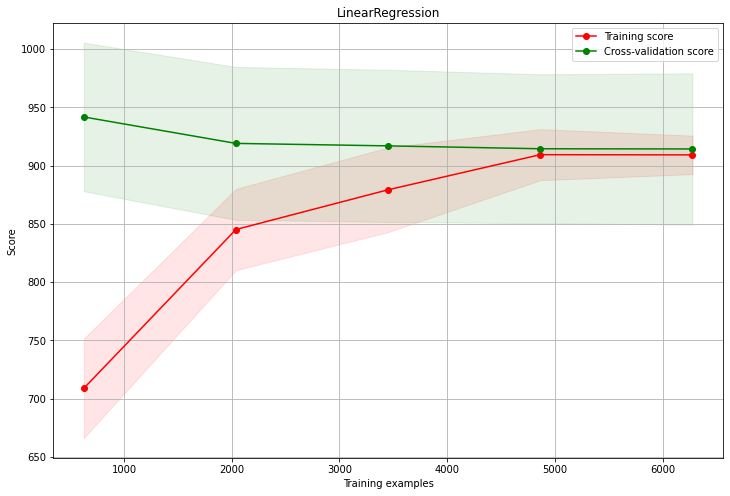

[DecisionTree]: 834.7979349174942 +/-61.778516226473734


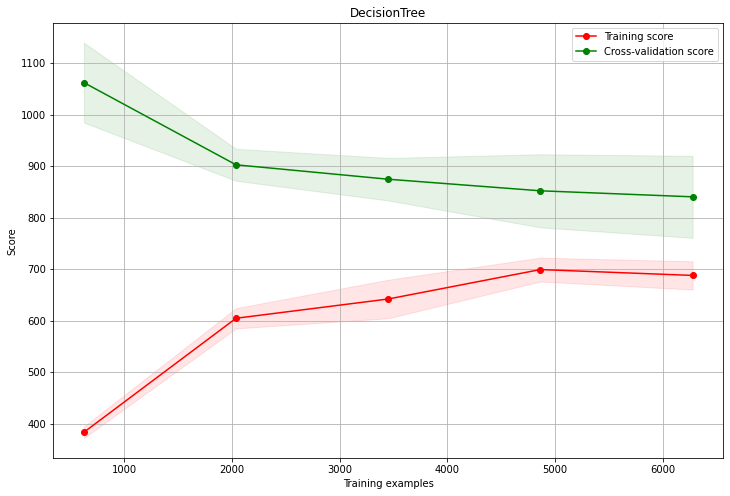

[RandomForest]: 751.4837520099317 +/-60.90279703976476


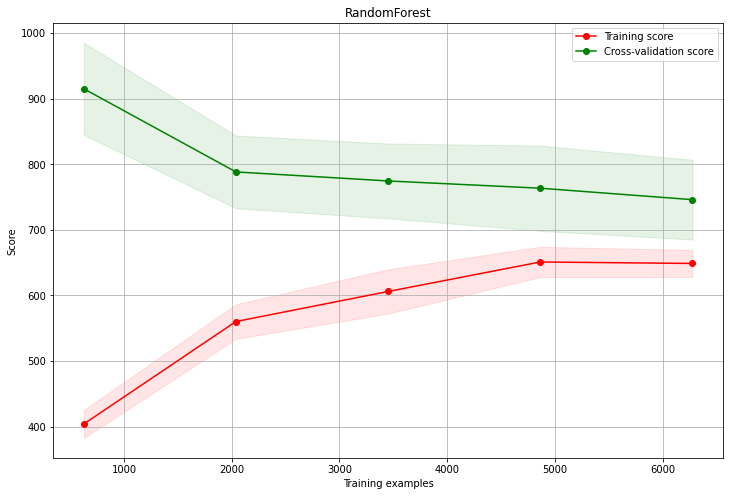

[XGB]: 660.0572029385252 +/-50.245899709195264


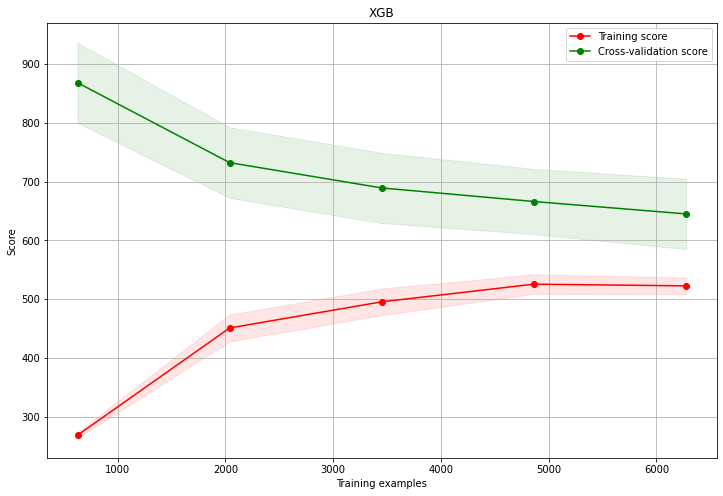

In [23]:
h.run(X,y,plot_lc=True)

Najmniejszy błąd (660 vs 1761) ma model XGB, nie jest przeuczony i nie dopaswuje się nadmiernie do zbioru treningowego (jak np. Regresja liniowa). Dlatego wybieram ten model do dalszej pracy i  spróbuję jeszcze poprawić ten wynik.

In [24]:
feats = one_hot_encoding_features+categorical_features+numeric_features
X = df_exp[feats].values
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

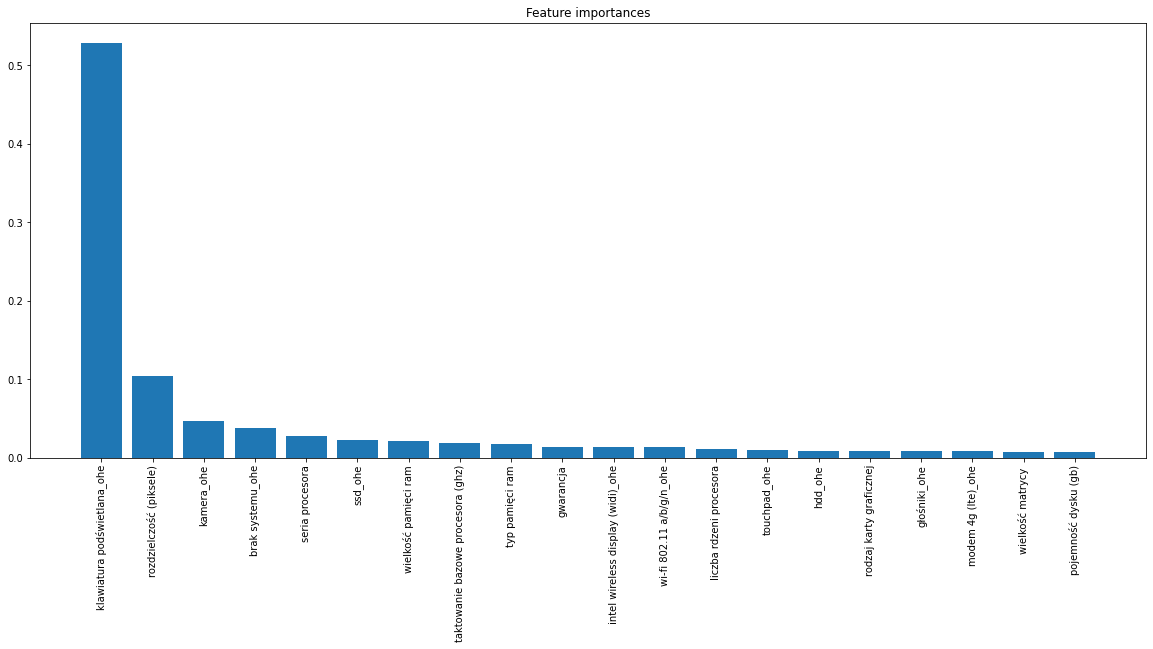

In [25]:
h.plot_feature_importances(model, feats, limit = 20)

Chęce sprawdzić jakie chechy wypływają na model. Ciekawe jest że na cenę mocną wpływa podświetlana klawiatura. 

In [26]:
h.run_cv(model, X, y, target_log=True) 

(666.176835897179, 52.6150186112338)

Zamiana zmienniej docelowej na logarytm nie poprawia jakość modelu 

In [27]:
def exp(remove_,append_,feats):
    feats = feats
    for i in remove_:
        feats.remove(i)
    for i in append_:
        feats.append(i)
    X = df_exp[feats].values
    return h.run_cv(model, X, y)

In [28]:
exp(['rozdzielczość (piksele)'],['rozdzielczość (piksele)_fe'], one_hot_encoding_features+categorical_features+numeric_features)

(657.8682245514804, 38.91315175659847)

In [29]:
exp(['seria procesora'],['seria procesora_fe'], one_hot_encoding_features+categorical_features+numeric_features)

(653.3424961849669, 45.04220055220596)

In [30]:
exp(['wi-fi 802.11 a/b/g/n/ac_ohe','wi-fi 802.11 b/g/n/ac_ohe','wi-fi 802.11 a/b/g/n_ohe','wi-fi 802.11 b/g/n_ohe','wi-fi_ohe'],['wifi_fe'], one_hot_encoding_features+categorical_features+numeric_features)

(646.3863242996628, 44.313456212612195)

In [31]:
exp(['lan 10/100/1000 mbps_ohe','lan 10/100 mbps_ohe'],['lan_fe'], one_hot_encoding_features+categorical_features+numeric_features)

(649.929602281482, 45.121002102817066)

Wszystkie dodatkowe zmiene poprawiły nieznacznie jakoś modelu 

### Klasteryzacja 
Nie znam się na cenach komuputerów wieć by bardziej zapoznać się jakie mogę być typamy, postam się z je skasteryzować na postawie cech 

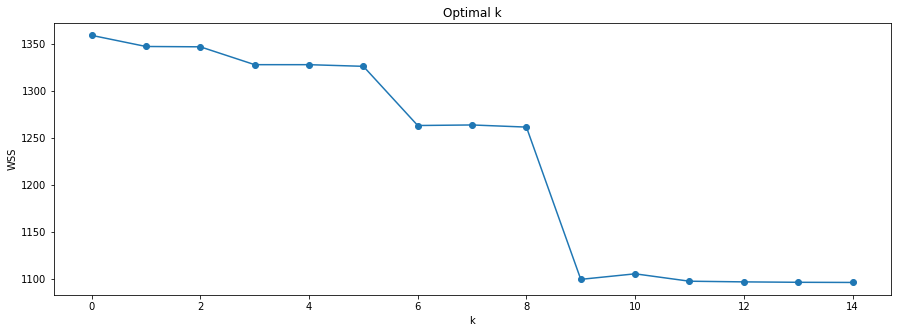

In [32]:
k_max = 15

xs = range(k_max)
wss = h.calculate_WSS(X, k_max)

plt.figure(figsize=(15, 5))
plt.title("Optimal k")
plt.ylabel('WSS')
plt.xlabel('k')
plt.plot(xs, wss, 'o-');

Łokieć występuje w miejscu 9 klastów co oznacza że mogę tą liczbę przyjąć jako optymalna (nie chce poświęcać w tym miejscu dużo czasu na optymalny wybór) 

In [33]:
kmeans = KMeans(n_clusters=9).fit(X)
y_cluster = kmeans.predict(X)
df_exp['y_cluster'] = y_cluster

In [34]:
feats = one_hot_encoding_features + categorical_features + numeric_features + ['y_cluster']
X = df_exp[feats].values
h.run_cv(model, X, y)

(654.1023958416938, 40.59147940551861)

Mamy nieznaczną poprawę modelu (nie będę dodawać jednak tej cechy do modelu) 

In [35]:
df_exp['price'] = y 

In [36]:
Counter(y_cluster)

Counter({3: 1463,
         0: 1489,
         8: 1785,
         1: 1993,
         4: 737,
         6: 246,
         2: 31,
         7: 101,
         5: 1})

In [37]:
df_exp.groupby('y_cluster').mean()

,wielkość pamięci ram,taktowanie bazowe procesora (ghz),pojemność dysku (gb),wielkość matrycy,rodzaj karty graficznej,rozdzielczość (piksele),liczba rdzeni procesora,typ pamięci ram,seria procesora,gwarancja,modem 3g (wwan)_ohe,wi-fi 802.11 a/b/g/n/ac_ohe,wi-fi 802.11 b/g/n/ac_ohe,wi-fi 802.11 a/b/g/n_ohe,modem 4g (lte)_ohe,gps_ohe,intel wireless display (widi)_ohe,nfc (near field communication)_ohe,bluetooth_ohe,wi-fi 802.11 b/g/n_ohe,lan 10/100/1000 mbps_ohe,wi-fi_ohe,lan 10/100 mbps_ohe,klawiatura_ohe,touchpad_ohe,klawiatura podświetlana_ohe,klawiatura numeryczna_ohe,kamera_ohe,czytnik kart pamięci_ohe,mikrofon_ohe,głośniki_ohe,windows 10 home_ohe,windows 7 professional 64-bit_ohe,windows 10 professional_ohe,brak systemu_ohe,windows 8.1 professional 64-bit_ohe,windows 8.1 home 64-bit_ohe,windows 7 home 64-bit_ohe,windows 8.1 home 32-bit_ohe,windows 7 professional 32-bit_ohe,linux_ohe,windows 8.1 professional 32-bit_ohe,emmc_ohe,hdd_ohe,hybrydowy_ohe,ssd_ohe,rozdzielczość (piksele)_fe,seria procesora_fe,wifi_fe,lan_fe,price
y_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.766958,1.058146,76.080591,11.591672,0.461383,2.243116,0.447952,1.370719,11.002686,1.186702,0.606447,0.025520,0.075218,0.250504,0.332438,0.079919,0.022834,0.122901,0.303559,0.002686,0.008731,0.010745,0.012089,0.642042,0.301545,0.096709,0.689725,0.668234,0.610477,0.674950,0.630625,0.081263,0.000000,0.445937,0.127602,0.000000,0.002015,0.034923,0.000672,0.009402,0.000672,0.003358,0.062458,0.093351,0.008731,0.651444,0.586971,0.321692,0.364674,0.020819,2633.204426
1,9.513798,2.082519,991.207225,14.910687,0.353236,2.533367,0.763673,1.454591,11.708480,1.144506,0.868038,0.045158,0.128450,0.405921,0.539890,0.133467,0.022077,0.198695,0.413447,0.003011,0.023583,0.007526,0.019067,0.901154,0.516809,0.315605,0.953337,0.909684,0.877070,0.941295,0.886603,0.181134,0.000000,0.570998,0.151029,0.001004,0.000000,0.031109,0.003512,0.024586,0.000000,0.001004,0.000000,0.811340,0.022579,0.156548,0.650276,0.634722,0.590065,0.042649,3307.954190
2,17.935484,2.764516,2606.451613,15.451613,0.000000,3.000000,1.870968,1.838710,13.000000,1.000000,1.000000,0.000000,0.322581,0.483871,0.677419,0.258065,0.000000,0.322581,0.193548,0.000000,0.000000,0.000000,0.096774,1.000000,0.451613,0.774194,1.000000,1.000000,1.000000,1.000000,0.806452,0.258065,0.000000,0.612903,0.096774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.806452,0.096774,6127.806452
3,9.160629,2.034081,496.579631,14.753247,0.501025,2.450444,0.636364,1.269310,11.410116,1.191388,0.894053,0.028708,0.139440,0.402597,0.537936,0.147642,0.069720,0.159945,0.451128,0.002734,0.018455,0.021189,0.025974,0.942584,0.448394,0.314422,0.967191,0.913192,0.896104,0.943951,0.915243,0.130554,0.001367,0.504443,0.252905,0.000684,0.000000,0.056733,0.002051,0.035543,0.000684,0.002734,0.000000,0.396446,0.019139,0.573479,0.563226,0.572796,0.594668,0.044429,3474.552659
4,13.937585,2.461194,1185.312076,15.274084,0.107191,3.211669,1.499322,1.895522,12.530529,1.021710,0.894166,0.027137,0.185889,0.351425,0.674355,0.185889,0.016282,0.246947,0.369064,0.000000,0.014925,0.000000,0.033921,0.951153,0.510176,0.698779,0.968792,0.860244,0.937585,0.972863,0.924016,0.339213,0.000000,0.522388,0.122117,0.000000,0.000000,0.000000,0.000000,0.001357,0.000000,0.000000,0.000000,0.994573,0.000000,0.997286,0.967436,0.948440,0.564450,0.048847,4662.596825
5,16.000000,2.600000,10000.000000,15.000000,0.000000,3.000000,2.000000,2.000000,13.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4597.000000
6,14.764228,2.552276,1537.918699,15.487805,0.081301,3.113821,1.467480,1.638211,12.6

Klastry różnią się od siebie:
- wielkościa pamięci ram, 
- pojemnościa dysku
- wielkością matrycy
- liczbą rdzeni,
- podświetlaną klawiaturą 
- klasa 3 jest znacznie droższa 

Podsumowując można by powiedzieć że:
- klaster 1 to małe przenośne komputery
- klaster 3 to komputery premium / gamingowe (dedykowana karta graficzna?) 

In [38]:
df_exp = df_exp.drop('price',axis = 1)

### Dobranie parametrów do modelu

In [39]:
drop_columns = Pipeline(steps=[
            ('drop_wifi_1' , dt.DFTransform(lambda df: dt._drop(df, 'wi-fi 802.11 a/b/g/n/ac_ohe'))),
            ('drop_wifi_2' , dt.DFTransform(lambda df: dt._drop(df, 'wi-fi 802.11 b/g/n/ac_ohe'))),
            ('drop_wifi_3' , dt.DFTransform(lambda df: dt._drop(df, 'wi-fi 802.11 a/b/g/n_ohe'))),
            ('drop_wifi_4' , dt.DFTransform(lambda df: dt._drop(df, 'wi-fi 802.11 b/g/n_ohe'))),
            ('drop_wifi_5' , dt.DFTransform(lambda df: dt._drop(df, 'wi-fi_ohe'))),
            ('drop_lan_1' , dt.DFTransform(lambda df: dt._drop(df, 'lan 10/100/1000 mbps_ohe'))),
            ('drop_lan_2' , dt.DFTransform(lambda df: dt._drop(df, 'lan 10/100 mbps_ohe')))
             ])

df = drop_columns.fit_transform(df)
#PS można to było rozbić lepiej na etapie filtorwania kolumny 'komunikacja'. 
#Nie chcę tracić na przejrzystości 'krok po korku' wiec zostawię to w takij formie

In [40]:
one_hot_encoding_features = h.get_one_hot_encoding_features(df,qc.komunikacja + qc.multimedia + qc.sterowanie + qc.typ_dysku_twardego + qc.system_operacyjny ) 

converting_data_to_numbers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('hot',one_hot_encoding_transformer,one_hot_encoding_features),
        ('eng',engineering_transformer,engineering_features)
    ])

get_x_2 = Pipeline(steps=[('converting_data_to_numbers', converting_data_to_numbers)])
X = get_x_2.fit_transform(df)

Na koniec postatam się dobrać najbardziej optymalne parametry modelu 

In [41]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 0, #int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'objective': 'reg:squarederror',
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    mean_score, std_score = h.run_cv(model, X, y)

    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'n_estimators': hp.quniform ('x_n_estimators', 10, 100, 1),
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

The best params:  {'x_colsample_bytree': 0.9632410444673761, 'x_learning_rate': 0.17980177455375262, 'x_max_depth': 12.0, 'x_min_child_weight': 10.0, 'x_n_estimators': 93.0, 'x_reg_alpha': 1.2014701555284388, 'x_reg_lambda': 0.8984909358203461, 'x_seed': 3350.0, 'x_subsample': 0.8778403114778917}


In [42]:
model = xgb.XGBRegressor(**best_params)
model.fit(X, y)

[16:25:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None,
             x_colsample_bytree=0.9632410444673761,
             x_learning_rate=0.17980177455375262, x_max_depth=12.0,
             x_min_child_weight=10.0, ...)

[16:25:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<module 'matplotlib.pyplot' from '/Users/ewa.suknarowska/.pyenv/versions/3.7.9/envs/lpp/lib/python3.7/site-packages/matplotlib/pyplot.py'>

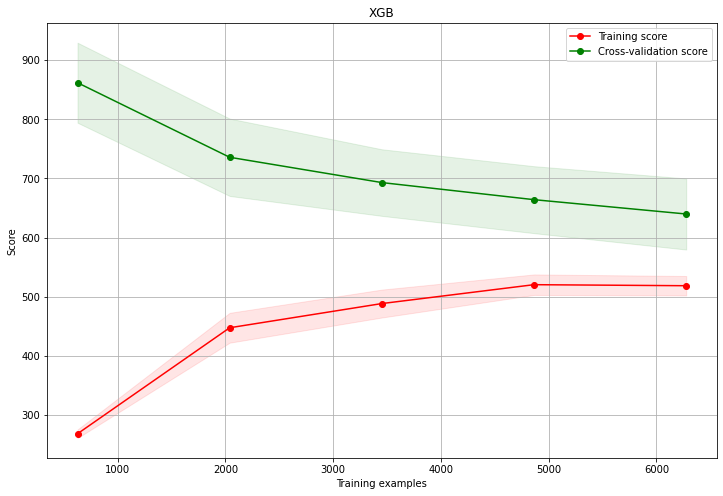

In [43]:
h.plot_learning_curve(model, 'XGB', X, y)

### Pipeline na danych testowych i wygenerowanie prognozy 



In [44]:
test = pd.read_json("data/hidden-Xs.json")
test.reset_index(inplace=True)
index_ = test[['index']]
test = test.drop('index', axis=1) 
test.insert(loc=0, column='buynow_price', value=np.nan)

In [45]:
test = preprocessor.transform(test)
test = feature_engineering.transform(test)
test = drop_columns.transform(test)
X_test = get_x_2.transform(test)

/Users/ewa.suknarowska/.pyenv/versions/3.7.9/envs/lpp/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:861: UserWarning: unknown class(es) ['inny'] will be ignored
  .format(sorted(unknown, key=str)))


In [46]:
y_pred = model.predict(X_test)

In [47]:
y_pred

array([2922.4343, 1370.4507, 2094.485 , ..., 4205.661 , 3612.4963,
       2972.6543], dtype=float32)

In [48]:
index_['pred'] = y_pred

In [49]:
index_.to_json('pred/pred.json',orient="columns")

### Bonus: K najbliższych sąsiadów
Pomysł który pojawił mi się podczas rozwiązywania zadania i klasteryzacji, by spróbować dobrać cenne patrzać na podobne modele laptopów, zostawiam bo go też rozważałam, ale daje gorszy wynik 

In [50]:
nbrs = NearestNeighbors(n_neighbors =20 , metric = 'cosine').fit(X)

In [51]:
def sasiedzi(X, y, folds=4, cv_type=KFold):
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        nbrs = NearestNeighbors(n_neighbors = 10 , metric = 'cosine').fit(X_train)
        y_pred = []
        for i in X_test: 
            distances, indices = nbrs.kneighbors([i])
            price = np.mean(y_train [indices])
            y_pred.append(price) 

        score = np.sqrt(mean_squared_error(y_test, y_pred)) 
        scores.append( score )
        
    return np.mean(scores), np.std(scores)

In [52]:
sasiedzi(X, y)

(909.892456758387, 26.629097151652225)